# Data Assignment 1 - `t54zheng` (20939203)



In [1]:
import pandas as pd
import scipy.stats as stats
from math import sqrt
import warnings
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from math import sqrt
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

In [2]:
# Import raw data
data_file = "djreturns.xlsx"

dj27 = pd.read_excel(data_file, sheet_name="dj27")
individual_dj27_returns = pd.read_excel(data_file, sheet_name="returns")
sp500_returns = pd.read_excel(data_file, sheet_name="sp500")

## Task 2 - *Basic Statistics*

For each of the 27 stocks in `dj27`, and the market return `sp500_returns`, we want to find these statistics on their returns:
- The arithmetic mean
- standard deviation
- skewness
- kurtosis

In [3]:
# Let's see what our data looks like
dj27.head()

,PERMNO,COMNAM,TICKER
0,10107,MICROSOFT CORP,MSFT
1,10145,HONEYWELL INTERNATIONAL INC,HON
2,11308,COCA COLA CO,KO
3,12490,INTERNATIONAL BUSINESS MACHS COR,IBM
4,14008,AMGEN INC,AMGN


In [4]:
individual_dj27_returns.head()

,PERMNO,DATE,COMNAM,TICKER,PRC,RET,SHROUT
0,10107,2000-01-31,MICROSOFT CORP,MSFT,97.8750,-0.161670,5160025
1,10107,2000-02-29,MICROSOFT CORP,MSFT,89.3750,-0.086845,5160025
2,10107,2000-03-31,MICROSOFT CORP,MSFT,106.2500,0.188811,5242000
3,10107,2000-04-28,MICROSOFT CORP,MSFT,69.7500,-0.343529,5262405
4,10107,2000-05-31,MICROSOFT CORP,MSFT,62.5625,-0.103047,5262405


In [5]:
# We need to group the data in individual_dj27_returns based on stock.
# Note that using PERMNO is a better idea since COMNAM can change.

# Let's show that our data actually has this issue:
duplicate_comnam_df = individual_dj27_returns[["PERMNO", "COMNAM"]].drop_duplicates().groupby("PERMNO").agg({'COMNAM': lambda x: list(x)})
duplicate_comnam_df

,COMNAM
PERMNO,
10107,[MICROSOFT CORP]
10145,[HONEYWELL INTERNATIONAL INC]
11308,[COCA COLA CO]
12490,[INTERNATIONAL BUSINESS MACHS COR]
14008,[AMGEN INC]
14541,"[CHEVRON CORP, CHEVRONTEXACO CORP, CHEVRON COR..."
14593,"[APPLE COMPUTER INC, APPLE INC]"
18163,[PROCTER & GAMBLE CO]
18542,[CATERPILLAR INC]


We see many securities have multiple comnames as they have changed their company name over the period of the data, but PERMNO remains the same.

In [6]:
# So let's make a new dataframe for each PERMNO we have in dj27, and store them in a dict by PERMNO.
returns_dict = {} # permno -> dataframe(permno_returns)
permnos = dj27["PERMNO"]
for permno in permnos:
    returns_df = individual_dj27_returns[individual_dj27_returns["PERMNO"] == permno]
    returns_dict[permno] = returns_df

In [7]:
# Now that we have our data nicely organized, let's make a new dataframe to present our statistics
# We'll have every row describes the statistics for each return

stats_df = pd.DataFrame(columns=["permno", "Common Name(s)", "Mean (%)", "Standard Deviation (%)", "Skewness", "Kurtosis"])

# add using .loc[-1]
# First add the stats for the market portfolio
market_stats = {
    "permno": "market",
    "Common Name(s)": ["Market"], 
    "Mean (%)": sp500_returns["SPRTRN"].mean(),
    "Standard Deviation (%)": sp500_returns["SPRTRN"].std(),
    "Skewness": stats.skew(sp500_returns["SPRTRN"]),
    "Kurtosis": stats.kurtosis(sp500_returns["SPRTRN"])
    }

# stats_df = stats_df.append(market_stats, ignore_index=True)
stats_df.loc[0] = [v for v in market_stats.values()]

# Now we'll add the rest of the securities from dj27
duplicate_comnam_dict = duplicate_comnam_df.to_dict()['COMNAM']

i = 1
for permno, df in returns_dict.items():
    permno_stats = {
        "permno": permno,
        "Common Name(s)": duplicate_comnam_dict[permno], 
        "Mean (%)": df["RET"].mean(),
        "Standard Deviation (%)": df["RET"].std(),
        "Skewness": stats.skew(df["RET"]),
        "Kurtosis": stats.kurtosis(df["RET"])
    }
    # stats_df = stats_df.append(permno_stats, ignore_index=True)
    stats_df.loc[i] = [v for v in permno_stats.values()]
    i += 1

# Now we need to annualize the mean and standard deviation of the returns (currently monthly)
stats_df["Mean (%)"] = stats_df["Mean (%)"] * 12 # Annualize by multiplying by 12 (no compounding)
stats_df["Standard Deviation (%)"] = stats_df["Mean (%)"] * sqrt(12) # Annualizing stdev

# Format the results
stats_df["Mean (%)"] *= 100
stats_df["Standard Deviation (%)"] *= 100

# Round to 4 decimal places
stats_df = stats_df.round(4)
stats_df
\

,permno,Common Name(s),Mean (%),Standard Deviation (%),Skewness,Kurtosis
0,market,[Market],6.5021,22.5238,-0.5312,1.0848
1,10107,[MICROSOFT CORP],14.1157,48.8983,0.2160,3.3232
2,10145,[HONEYWELL INTERNATIONAL INC],12.5522,43.4822,-0.1321,7.7921
3,11308,[COCA COLA CO],7.5283,26.0787,-0.5014,1.1777
4,12490,[INTERNATIONAL BUSINESS MACHS COR],6.5405,22.6570,0.4121,3.5562
5,14008,[AMGEN INC],10.3270,35.7739,0.5216,1.8024
6,14541,"[CHEVRON CORP, CHEVRONTEXACO CORP, CHEVRON COR...",10.7444,37.2197,0.4071,2.2700
7,14593,"[APPLE COMPUTER INC, APPLE INC]",33.2421,115.1539,-0.6328,3.4377
8,18163,[PROCTER & GAMBLE CO],9.3172,32.2759,-1.5059,9.1691
9,18542,[CATERPILLAR INC],17.3336,60.0455,-0.0672,1.9528


In [8]:
# The market portfolio
stats_df[stats_df["permno"] == "market"]

,permno,Common Name(s),Mean (%),Standard Deviation (%),Skewness,Kurtosis
0,market,[Market],6.5021,22.5238,-0.5312,1.0848


### Statistics of the market portfolio

- TODO: Comment on skewness and kurtosis of the market return vs a normal dist

## Task 3 - Equal-weighted Portfolio

In [9]:
individual_dj27_returns

,PERMNO,DATE,COMNAM,TICKER,PRC,RET,SHROUT
0,10107,2000-01-31,MICROSOFT CORP,MSFT,97.875000,-0.161670,5160025
1,10107,2000-02-29,MICROSOFT CORP,MSFT,89.375000,-0.086845,5160025
2,10107,2000-03-31,MICROSOFT CORP,MSFT,106.250000,0.188811,5242000
3,10107,2000-04-28,MICROSOFT CORP,MSFT,69.750000,-0.343529,5262405
4,10107,2000-05-31,MICROSOFT CORP,MSFT,62.562500,-0.103047,5262405
...,...,...,...,...,...,...,...
7123,92655,2021-08-31,UNITEDHEALTH GROUP INC,UNH,416.269989,0.009825,942917
7124,92655,2021-09-30,UNITEDHEALTH GROUP INC,UNH,390.739990,-0.057847,942917
7125,92655,2021-10-29,UNITEDHEALTH GROUP INC,UNH,460.470001,0.178456,942917
7126,92655,2021-11-30,UNITEDHEALTH GROUP INC,UNH,444.220001,-0.035290,941851


To make our equally-weighted index we will allocate each ticker an equal weight of $\dfrac{1}{n}$, and since we have 27 stocks, we allocate each stock a weight of $\dfrac{1}{27}$.

In [10]:
# We only need to use monthly returns (already calculated) to calculate the index. So let's align the data.
# This df will hold our (unindexed [to 1000]) portfolio

# We'll just pull the dates from the sp500 returns since that, and the dj data all have aligned dates
portfolio_df = pd.DataFrame(sp500_returns["DATE"])

for permno, df in returns_dict.items():
    portfolio_df.loc[:, permno] = list(df["RET"])

# Just to validate, none of our cells are null so we can safely continue 
portfolio_df.isnull().sum().sum() # returns number of null cells

0

In [11]:
num_stocks = 27
weight = 1 / num_stocks
starting_level = 1000

portfolio_df.iloc[:, 1:] *= weight # Weighted average of portfolio returns
portfolio_df.loc[:, "Weighted Return"] = portfolio_df.iloc[:, 1:].sum(axis=1)
portfolio_df

,DATE,10107,10145,11308,12490,14008,14541,14593,18163,18542,...,57665,59176,59328,59459,65875,66181,76076,86868,92655,Weighted Return
0,2000-01-31,-0.005988,-0.006220,-0.000517,0.001502,0.002235,-0.001283,0.000338,-0.002765,-0.003384,...,-0.003036,-0.000284,0.007481,-0.003848,0.000457,-0.006532,0.000821,-0.000960,-0.000087,-0.018881
1,2000-02-29,-0.003216,0.000241,-0.005683,-0.003095,0.002617,-0.003670,0.003882,-0.004833,-0.006436,...,-0.013889,-0.006871,0.005275,-0.009585,-0.007774,0.000777,0.007674,0.000354,-0.001310,-0.083481
2,2000-03-31,0.006993,0.003511,-0.001156,0.005497,-0.003700,0.008802,0.006846,-0.013224,0.004621,...,0.014727,0.004071,0.006207,0.019897,0.009224,0.004310,0.006287,0.005105,0.006179,0.119399
3,2000-04-28,-0.012723,0.002329,0.000247,-0.002040,-0.003244,-0.002930,-0.003204,0.002340,0.000305,...,0.003564,0.000200,-0.001439,0.001628,-0.000903,-0.004594,-0.003825,-0.004181,0.004387,-0.013185
4,2000-05-31,-0.003817,-0.000744,0.004801,-0.001327,0.005043,0.003464,-0.011960,0.004184,-0.001115,...,-0.000480,0.003097,-0.000612,0.001949,-0.003985,-0.005039,-0.006619,-0.007819,0.004374,-0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-08-31,0.002279,-0.000150,-0.000468,0.000268,-0.002185,-0.001346,0.001572,0.000042,0.000738,...,-0.000552,-0.000993,0.000474,0.002684,-0.000518,-0.000227,0.002441,0.004014,0.000364,0.014411
260,2021-09-30,-0.002449,-0.003135,-0.002249,-0.000372,-0.002115,0.001791,-0.002520,-0.000674,-0.003320,...,-0.004386,0.000350,-0.000534,-0.001582,-0.000667,0.000424,-0.002880,-0.003178,-0.002142,-0.041907
261,2021-10-29,0.006529,0.001106,0.002753,-0.003687,-0.000989,0.004761,0.002172,0.001076,0.002537,...,0.005626,0.001477,-0.002975,0.002161,-0.000261,0.004906,0.001300,0.003460,0.006609,0.048706
262,2021-11-30,-0.000046,-0.002609,-0.002300,-0.000348,-0.001133,-0.000091,0.003887,0.000412,-0.001935,...,0.000432,-0.004578,0.000414,-0.003207,-0.001901,0.002876,-0.000748,-0.002900,-0.001307,-0.036266


To avoid look-ahead bias, we calculate the index level $L_t$ as $L_{t-1} \times r_{p,t}$

In [12]:
# Now we'll use this data to populate our index_df 
index_returns_df = portfolio_df[["DATE", "Weighted Return"]]

index_df = pd.DataFrame(columns = ["Date", "Index Level"])
index_df.loc[0] = ["1999-12-31", 1000.00]

for index, row in index_returns_df.iterrows():
    index_df.loc[index + 1, "Date"] = str(index_returns_df.loc[index, "DATE"])
    index_df.loc[index + 1, "Index Level"] = (1+ index_returns_df.loc[index, "Weighted Return"]) * index_df.loc[index, "Index Level"]
index_df["Date"] = pd.to_datetime(index_df["Date"], format='mixed') # Fix datetime

index_df["Index Level"] = index_df["Index Level"].round(2)
index_df

,Date,Index Level
0,1999-12-31,1000.00
1,2000-01-31,981.12
2,2000-02-29,899.21
3,2000-03-31,1006.58
4,2000-04-28,993.31
...,...,...
260,2021-08-31,11319.80
261,2021-09-30,10845.42
262,2021-10-29,11373.66
263,2021-11-30,10961.18


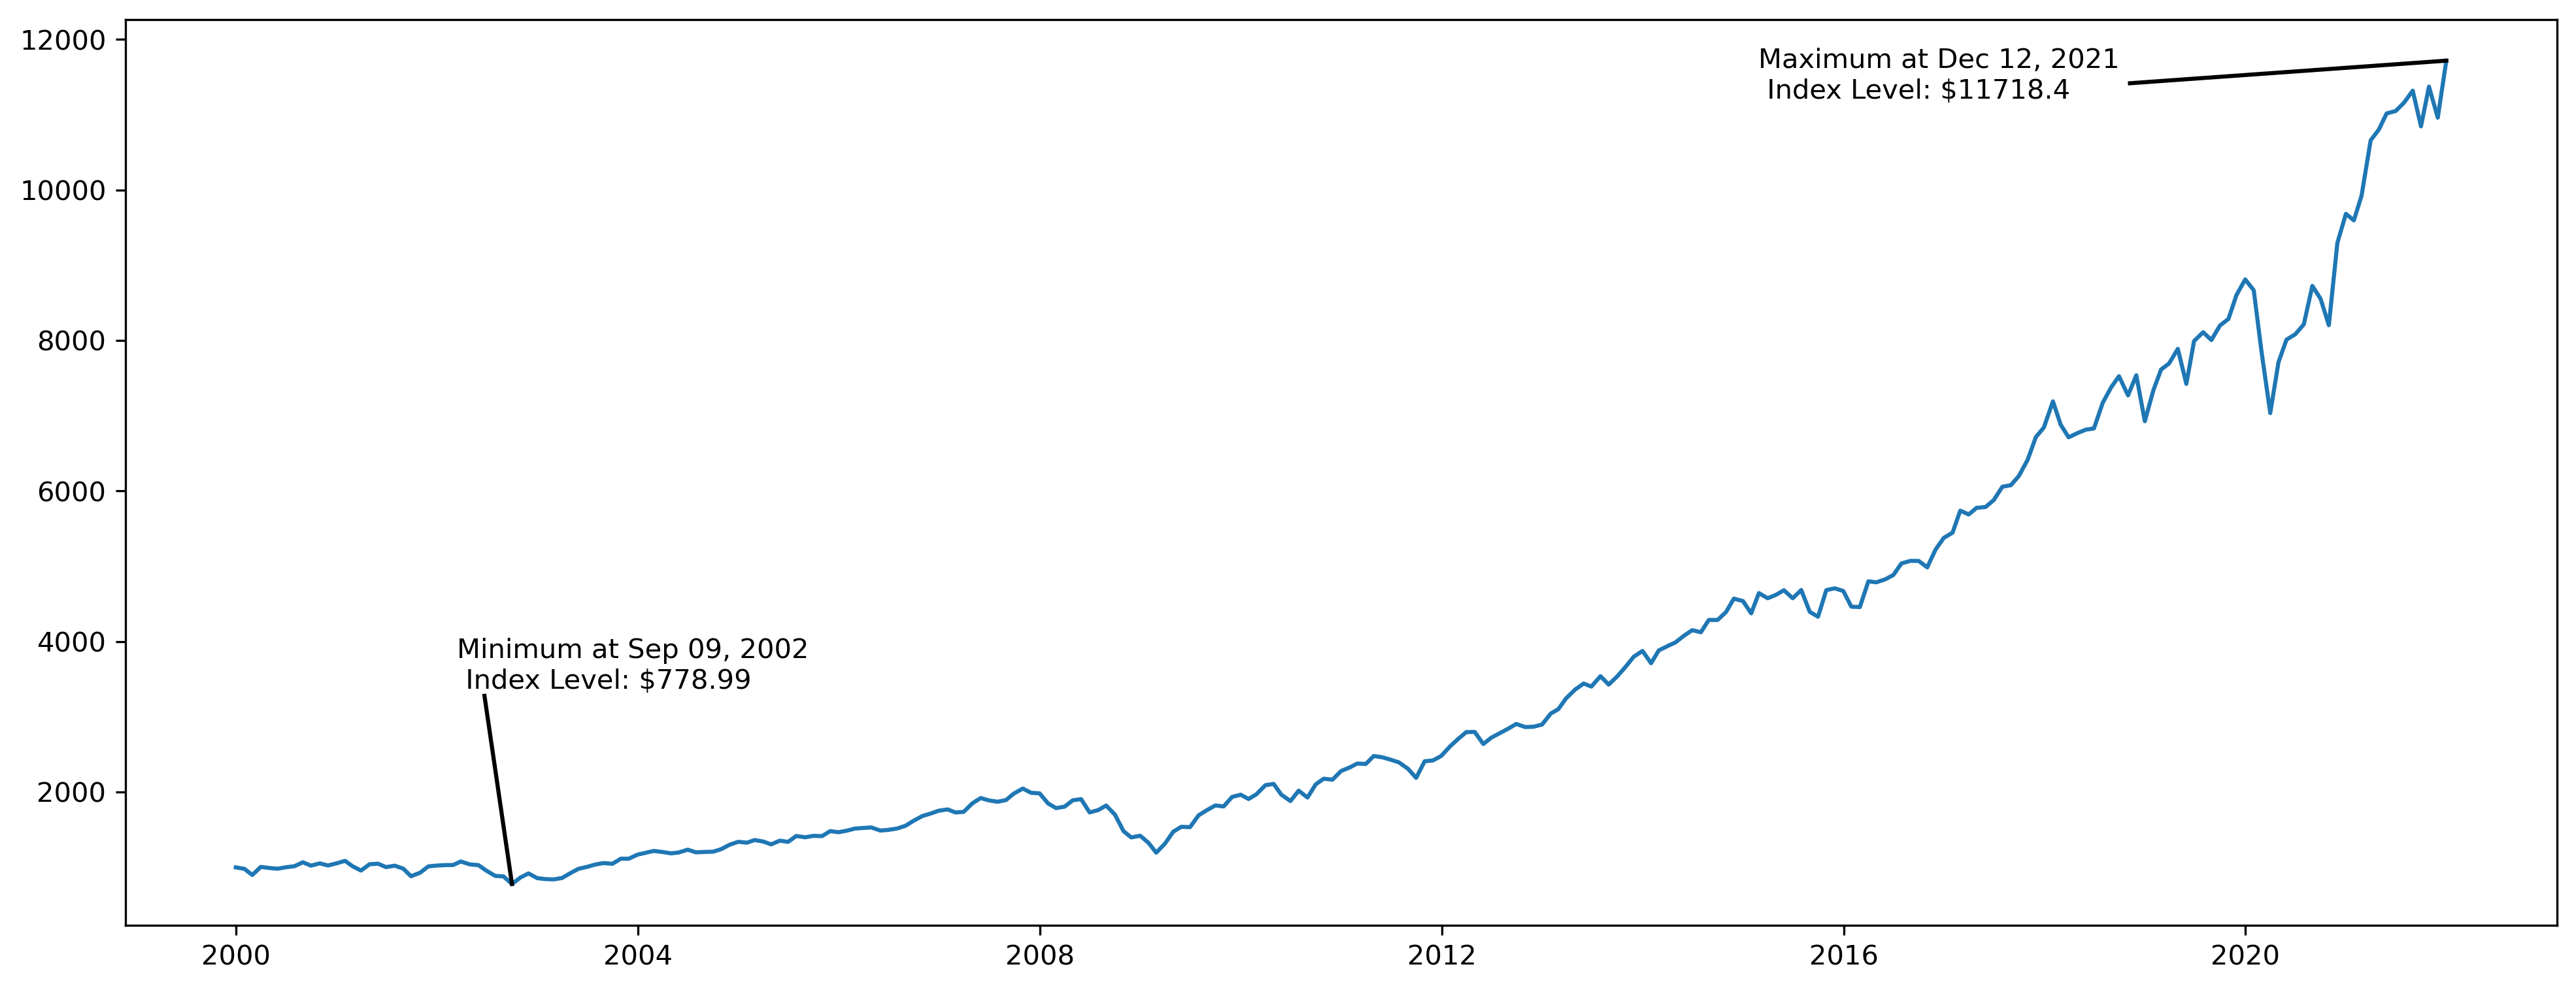

In [13]:
index_df.set_index(["Date"])

plt.figure(figsize=(16, 6), dpi=300)

plt.plot(index_df["Date"], index_df["Index Level"], label="Equally Weighted Index")

# We need to find (and annotate the min and max)

# Min
min_y = min(index_df["Index Level"])
min_x = index_df[index_df["Index Level"] == min_y]["Date"].iloc[0]

# Plot minimum
plt.plot([min_x, min_x - timedelta(100)], [min_y, min_y + 2500], linestyle="-", color="black")
plt.text(min_x - timedelta(200), min_y + 2600, f"Minimum at {min_x.strftime('%b %m, %Y')}\n Index Level: ${min_y}")

# Max
max_y = max(index_df["Index Level"])
max_x = index_df[index_df["Index Level"] == max_y]["Date"].iloc[0]

# Plot maximum
plt.plot([max_x, max_x - timedelta(1150)], [max_y, max_y - 300], linestyle="-", color="black")
plt.text(max_x - timedelta(2500), max_y - 500, f"Maximum at {max_x.strftime('%b %m, %Y')}\n Index Level: ${max_y}")

plt.show()

### Task 4 Mean-variance Analysis

a) We will find the global minimum variance portfolio using the aggregate data from 2000-2021

We already computed each stock's **annualized** average monthly return and standard deviation in `stats_df`, so we can use this to find our global minimum portfolio by adjusting our portfolio weights

We use this data to compute our return variance and covariance matrix between each stock

In [14]:
# First, according to PyPortfolioOpt's documentation, we need to make different dataframes for:
# - The average annualized returns for each stock
# - A covariance matrix for each stock

# Dataframe of each stock as a column and stock price
price_df = pd.DataFrame(columns = ["Date"] + list(returns_dict.keys()))
price_df.Date = sp500_returns["DATE"] # Add dates

# price_df.loc["Date"] = sp500_returns["DATE"]
for permno, df in returns_dict.items():
    price_df[permno] = df["PRC"].values
price_df.set_index("Date", inplace=True)

In [15]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.cla import CLA
mu = mean_historical_return(price_df)
S = CovarianceShrinkage(price_df).ledoit_wolf()

In [16]:
mu

10107    2.263317
10145    3.085131
11308    0.029550
12490    0.182073
14008    2.350791
14541    0.383543
14593    0.673479
18163    0.586328
18542    3.559452
19502    0.818901
19561    3.247266
22111    0.931439
22592    0.847106
22752   -0.026428
26403    3.014383
43449    5.605089
47896    0.907941
55976    1.537476
57665    2.469470
59176   -0.006689
59328   -0.465059
59459    3.837368
65875   -0.154904
66181    5.743254
76076   -0.407887
86868    2.932914
92655    7.623920
dtype: float64

In [17]:
S

,10107,10145,11308,12490,14008,14541,14593,18163,18542,19502,...,55976,57665,59176,59328,59459,65875,66181,76076,86868,92655
10107,1.905587,0.478036,0.203939,0.657161,0.245581,0.379991,0.789369,-0.059890,0.409738,0.194076,...,0.221862,0.233145,0.622431,0.898031,0.325577,0.513784,0.396167,0.718054,0.735986,0.277122
10145,0.478036,1.698088,0.321589,0.559139,0.279292,0.533813,0.539594,0.205626,0.900608,0.532955,...,0.171794,0.329412,0.881611,0.750168,0.537600,0.441372,0.443504,0.717889,0.663996,0.435278
11308,0.203939,0.321589,0.983003,0.149554,0.110734,0.293494,-0.069342,0.254962,0.232832,0.206112,...,0.168407,0.224903,0.257228,0.101136,0.287217,0.235567,0.150813,0.155449,0.202809,0.118662
12490,0.657161,0.559139,0.149554,1.349027,0.376318,0.391212,0.852595,0.034463,0.467094,0.249924,...,0.201762,0.289334,0.607486,0.838264,0.374054,0.337451,0.484481,0.767847,0.752744,0.279530
14008,0.245581,0.279292,0.110734,0.376318,1.380683,0.141558,0.243760,0.241568,0.108656,0.263848,...,0.130838,0.002898,0.208628,0.462625,0.104257,0.095751,0.327313,0.418323,0.398564,0.206910
14541,0.379991,0.533813,0.293494,0.391212,0.141558,1.294881,0.317147,0.096235,0.590061,0.298608,...,0.106497,0.264107,0.486838,0.388018,0.474088,0.325764,0.316000,0.285407,0.515910,0.199657
14593,0.789369,0.539594,-0.069342,0.852595,0.243760,0.317147,4.486745,-0.062494,0.405822,0.097617,...,0.079484,0.426283,0.798939,1.157703,0.316366,0.235914,0.523028,0.893279,0.871849,0.202333
18163,-0.059890,0.205626,0.254962,0.034463,0.241568,0.096235,-0.062494,0.952041,0.167349,0.189221,...,0.098945,0.087264,0.183854,-0.004444,0.040111,0.049731,0.099371,0.265546,0.040880,0.175495
18542,0.409738,0.900608,0.232832,0.467094,0.108656,0.590061,0.405822,0.167349,2.091291,0.388108,...,0.235464,0.601517,1.029508,0.664427,0.515946,0.365440,0.489626,0.667356,0.816966,0.217830
19502,0.194076,0.532955,0.206112,0.249924,0.263848,0.298608,0.097617,0.189221,0.388108,1.459281,...,0.117362,0.219438,0.492021,0.266893,0.258592,0.302040,0.248150,0.290218,0.348839,0.403052


In [18]:
ef = CLA(mu, S, weight_bounds=(0, 1)) # Using CLA for better plotting

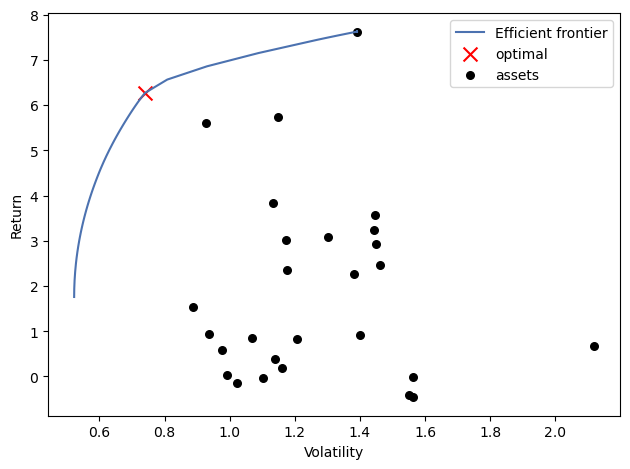

In [19]:
import pypfopt.plotting as plotting
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [20]:
# So our minimum variance portfolio is 

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([(10107, 0.02509),
             (10145, 0.0),
             (11308, 0.08463),
             (12490, 0.02136),
             (14008, 0.06677),
             (14541, 0.04508),
             (14593, 0.0297),
             (18163, 0.16323),
             (18542, 0.0),
             (19502, 0.03884),
             (19561, 0.0),
             (22111, 0.04111),
             (22592, 0.04735),
             (22752, 0.02634),
             (26403, 0.0),
             (43449, 0.07036),
             (47896, 0.0),
             (55976, 0.17777),
             (57665, 0.02493),
             (59176, 0.0),
             (59328, 0.0),
             (59459, 0.01647),
             (65875, 0.05121),
             (66181, 0.0121),
             (76076, 0.0),
             (86868, 0.0),
             (92655, 0.05765)])

In [21]:
ef.portfolio_performance(verbose=True)

Expected annual return: 175.6%
Annual volatility: 52.3%
Sharpe Ratio: 3.32


(1.756141358861549, 0.5226815885638276, 3.3216041981351307)

## Task 4 part a) but more manual i guess - note monthly returns

In [22]:
# We'll create a dataframe of returns for each stock (identified by permno)

returns_df = pd.DataFrame()

for permno, df in returns_dict.items():
    returns_df.loc[:, permno] = list(df["RET"])

In [23]:
# Next, we generate the covariance matrix for our returns
cov_df = returns_df.cov()

In [24]:
# We also need to determine the expected returns for each security
monthly_returns = returns_df.mean()

In [25]:
# We can now invoke pyportfopt's minimum variance portfolio class
ef = EfficientFrontier(monthly_returns, cov_df, weight_bounds=(0, 1))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([(10107, 0.01096),
             (10145, 0.0),
             (11308, 0.10726),
             (12490, 0.03119),
             (14008, 0.04935),
             (14541, 0.06357),
             (14593, 0.02561),
             (18163, 0.2326),
             (18542, 0.0),
             (19502, 0.02406),
             (19561, 0.0),
             (22111, 0.04938),
             (22592, 0.02399),
             (22752, 0.02014),
             (26403, 0.0),
             (43449, 0.02614),
             (47896, 0.0),
             (55976, 0.19584),
             (57665, 0.00158),
             (59176, 0.0),
             (59328, 0.01727),
             (59459, 0.00911),
             (65875, 0.0466),
             (66181, 0.0),
             (76076, 0.0),
             (86868, 0.0),
             (92655, 0.06534)])

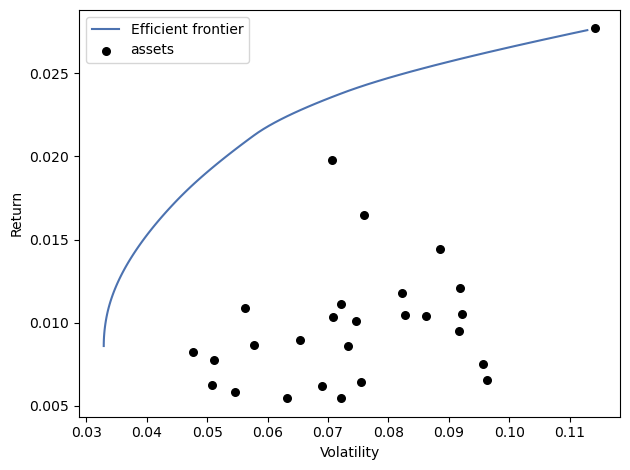

In [26]:
ef = EfficientFrontier(monthly_returns, cov_df, weight_bounds=(0, 1))

import pypfopt.plotting as plotting
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

## b) Monthly returns

In [27]:
monthly_returns.values

array([0.0117631 , 0.0104602 , 0.00627355, 0.00545042, 0.00860586,
       0.00895367, 0.02770172, 0.00776437, 0.0144447 , 0.00643044,
       0.0120587 , 0.008213  , 0.00867971, 0.00618013, 0.01006991,
       0.0108667 , 0.01041114, 0.00580039, 0.01650574, 0.00950675,
       0.00751816, 0.01034166, 0.00544742, 0.01110491, 0.00655743,
       0.01052464, 0.01977109])

In [28]:
Rlow = min(monthly_returns)
Rhigh = max(monthly_returns)

In [29]:
deltaR = ( 3 * Rhigh - Rlow / 3) / 10

In [30]:
deltaR

0.008128935398403744

In [31]:
target_returns = np.linspace(Rlow / 3, 3 * Rhigh, 11)

In [32]:
target_returns

array([0.00181581, 0.00994474, 0.01807368, 0.02620261, 0.03433155,
       0.04246048, 0.05058942, 0.05871836, 0.06684729, 0.07497623,
       0.08310516])

In [33]:
Rhigh * 3

0.08310516167503837

In [34]:
Rlow / 3

0.001815807691000924

In [35]:
target_returns
ef = EfficientFrontier(monthly_returns, cov_df, weight_bounds=(-100000, 100000)) # Need to bound weights to allow for short-selling
weights = ef.efficient_return(0.002)
ef.portfolio_performance()

(0.00826834917411172, 0.03146610185357247, -0.37283457863581343)

In [36]:
weights

OrderedDict([(10107, 0.0271250327447511),
             (10145, -0.1011266156374074),
             (11308, 0.0887677881411382),
             (12490, 0.0510134487616582),
             (14008, 0.0345444514945947),
             (14541, 0.0836520762913456),
             (14593, 0.0100986715693205),
             (18163, 0.2649811894710763),
             (18542, -0.0495236668831239),
             (19502, 0.0411465383645959),
             (19561, 0.0117278075228748),
             (22111, -0.0115298198031447),
             (22592, 0.1105572636487103),
             (22752, 0.0268314639365878),
             (26403, 0.0456317113017963),
             (43449, 0.0623147350920943),
             (47896, 0.0009633895550567),
             (55976, 0.1860405655818902),
             (57665, 0.0131364948695333),
             (59176, -0.0736028830427823),
             (59328, 0.0483862159878385),
             (59459, 0.0111451130768039),
             (65875, 0.0481127492831275),
             (66181, -0.004444

In [37]:
# Now we invoke the poyportfolioopt class's efficient_return function to dtermine the weights for the lowest return
portfolios = {f"{i}dR": None for i in range(0, 11)}

for i, target_return in enumerate(target_returns):
    ef = EfficientFrontier(monthly_returns, cov_df, weight_bounds=(-100, 100)) # Need to bound weights to allow for short-selling
    weights = ef.efficient_return(target_return)
    # weights = ef.clean_weights()
    portfolios[f"{i}dR"] = weights

## Using Tutorial Function instead because pyportfolioopt is weird

In [38]:
num_assets = 27
cov_mat = [list(cov_df.iloc[i, :].values) for i in range(27)]
mean_returns = monthly_returns.values
def minimum_variance_portfolio(returns, expected_return=None):
    init_guess = np.ones(num_assets) / num_assets

    # get portfolio volaitity by multiplying weights to covariance matrix
    def portfolio_volatility(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    # get portfolio returns by multiplying weights to mean_returns
    def portfolio_return(weights, mean_returns):
        return np.dot(weights.T, mean_returns)

    if expected_return is None:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    else:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
                       {"type": "eq", "fun": lambda x: portfolio_return(x, mean_returns) - expected_return}]
    bounds = [(-10000000000, 100000000000) for i in range(num_assets)]
                # there're no bounds in weights, set to arbitrarily large numbers

    # encoding the linear program depicted in Slide 22
    result = minimize(fun=portfolio_volatility,
                        x0=init_guess,
                        args=(cov_mat,),
                        method="SLSQP",
                        constraints=constraints,
                        bounds=bounds)

    # set variables to output
    w_min_var = result.x
    ret_min_var = np.sum(mean_returns * w_min_var)
    std_min_var = result.fun
    return w_min_var, ret_min_var, std_min_var

# define weights, standard dev and returns for mininimum variance portfolio
w_gmv, ret_gmv, std_gmv = minimum_variance_portfolio(monthly_returns.values)
print(w_gmv)
print(std_gmv)
print(ret_gmv)

[ 0.03456785 -0.04946188  0.101159    0.04141952  0.07579358  0.05437134
  0.03859305  0.15052721 -0.04099927  0.04900009 -0.01649492  0.09529338
  0.05726207  0.05762407  0.00377805  0.06832895 -0.01024899  0.12537413
  0.03540386 -0.06141673  0.01946703  0.02417908  0.06031439  0.03477691
 -0.00710651 -0.01091264  0.06940739]
0.0010576452104561367
0.009009839973149426


In [ ]:
portfolios_df = pd.DataFrame(columns = [" "])
portfolios_df.iloc[:,0] = monthly_returns.keys()
for portfolio, weights in portfolios.items():
    portfolios_df.loc[:, portfolio] = list(weights.values())
portfolios_df.set_index(" ", inplace=True)

In [ ]:
portfolios = []
for r in target_returns:
    w, ret, std = minimum_variance_portfolio(mean_returns, r)
    portfolios.append((w, ret, std))

portfolio_summary = pd.DataFrame(columns = [" "] + list(portfolios_df.columns))
portfolio_summary.loc[:, " "] = ["Monthly Return (%)", "stdev (%)"]

for i, p in enumerate(portfolios):
    portfolio_summary.iloc[:, i+1] = [p[1] * 100, p[2] * 100]
portfolio_summary.set_index(" ", inplace=True)
portfolio_summary

In [ ]:
target_returns

In [ ]:
# Now let's plot the efficient fronteir

plt.plot(portfolio_summary.loc["stdev (%)", :], portfolio_summary.loc["Monthly Return (%)", :])
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Monthly Return (%)")
plt.show()

***
## END TUTORIAL Content
***

In [ ]:
cov_mat = [list(cov_df.iloc[i, :].values) for i in range(27)]

In [ ]:
for i, target_return in enumerate(target_returns):
    print(i, target_return)

In [41]:
# Now we construct a dataframe summarizing all portfolios
portfolios_df = pd.DataFrame(columns = [" "])

In [42]:
portfolios_df.iloc[:,0] = monthly_returns.keys()

In [43]:
# Now we invoke the poyportfolioopt class's efficient_return function to dtermine the weights for the lowest return
portfolios = {f"{i}dR": None for i in range(0, 11)}

for i, target_return in enumerate(target_returns):
    ef = EfficientFrontier(monthly_returns, cov_df, weight_bounds=(-100, 100)) # Need to bound weights to allow for short-selling
    weights = ef.efficient_return(target_return)
    # weights = ef.clean_weights()
    portfolios[f"{i}dR"] = weights

for portfolio, weights in portfolios.items():
    portfolios_df.loc[:, portfolio] = list(weights.values())

In [44]:
portfolios_df.set_index(" ", inplace=True)
portfolios_df

,0dR,1dR,2dR,3dR,4dR,5dR,6dR,7dR,8dR,9dR,10dR
,,,,,,,,,,,
10107,0.027125,0.037485,0.087719,0.137953,0.188187,0.238421,0.288655,0.338889,0.389123,0.439357,0.489591
10145,-0.101127,-0.094359,-0.061545,-0.028730,0.004085,0.036900,0.069715,0.102530,0.135344,0.168159,0.200974
11308,0.088768,0.071944,-0.009635,-0.091214,-0.172793,-0.254373,-0.335952,-0.417531,-0.499110,-0.580689,-0.662268
12490,0.051013,0.029935,-0.072276,-0.174486,-0.276697,-0.378907,-0.481118,-0.583328,-0.685539,-0.787749,-0.889960
14008,0.034544,0.038068,0.055156,0.072243,0.089331,0.106418,0.123506,0.140593,0.157681,0.174768,0.191856
14541,0.083652,0.068191,-0.006783,-0.081756,-0.156730,-0.231704,-0.306677,-0.381651,-0.456624,-0.531598,-0.606571
14593,0.010099,0.041680,0.194822,0.347963,0.501104,0.654245,0.807387,0.960528,1.113669,1.266811,1.419952
18163,0.264981,0.259262,0.231532,0.203802,0.176072,0.148341,0.120611,0.092881,0.065150,0.037420,0.009690
18542,-0.049524,-0.029240,0.069116,0.167473,0.265829,0.364186,0.462542,0.560898,0.659255,0.757611,0.855968


In [45]:
portfolios_df.sum()

0dR     1.0
1dR     1.0
2dR     1.0
3dR     1.0
4dR     1.0
5dR     1.0
6dR     1.0
7dR     1.0
8dR     1.0
9dR     1.0
10dR    1.0
dtype: float64

In [46]:
# Portfolios are now balanced. We will now simulate each portfolio and compute the mean and standard deviation of each portfolio

portfolio_summary = pd.DataFrame(columns = [" "] + list(portfolios_df.columns))
portfolio_summary.iloc[:, 0] = ["Monthly Return (%)", "stdev (%)"]
for pf in portfolios_df:
    weights = portfolios_df[pf]
    
    # Weighted returns
    rp = (monthly_returns * weights).sum()

    varp = (weights.T * cov_df * weights).sum().sum() # From appendix var(r_p) = w'Vw
    # print(varp)
    # portfolios[pf] = portfolios_df[
    portfolio_summary.loc[:, pf] = [rp, sqrt(varp)]
portfolio_summary.set_index(" ", inplace=True)
portfolio_summary *= 100

In [47]:
portfolio_summary.astype(float).round(4)

,0dR,1dR,2dR,3dR,4dR,5dR,6dR,7dR,8dR,9dR,10dR
,,,,,,,,,,,
Monthly Return (%),0.8268,0.9945,1.8074,2.6203,3.4332,4.2460,5.0589,5.8718,6.6847,7.4976,8.3105
stdev (%),7.4606,7.2512,11.4981,19.2000,27.6021,36.2204,44.9307,53.6881,62.4730,71.2750,80.0887


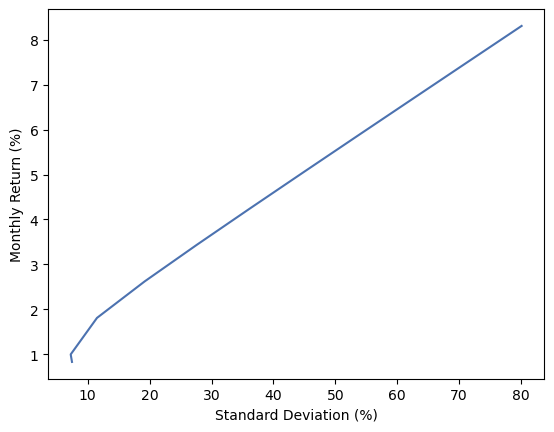

In [48]:
# Now let's plot the efficient fronteir

plt.plot(portfolio_summary.loc["stdev (%)", :], portfolio_summary.loc["Monthly Return (%)", :])
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Monthly Return (%)")
plt.show()

In [49]:
ef = CLA(monthly_returns, cov_df, weight_bounds=(-100, 100)) # Using CLA for better plotting

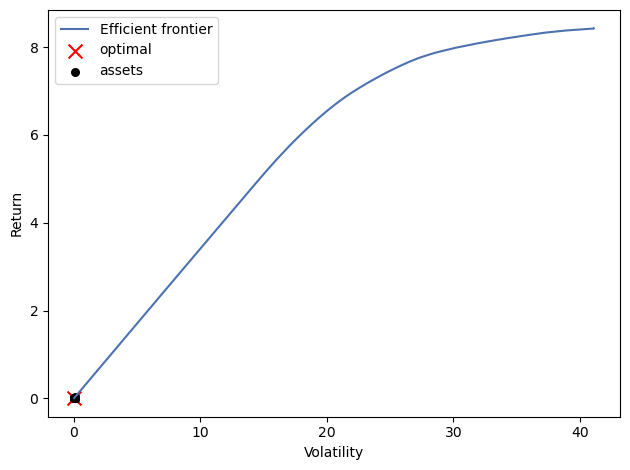

In [50]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()